## Week 10_Wed - LINEAR DATA FITTING WITH UNCERTANTIES

In [2]:
#standard importing
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt

In [3]:
#Read in the data to a numpy array
data = np.genfromtxt("HW10_2data.dat", names=True, dtype=None) # header

# print out all columns we just got for free
data.dtype# name x, dtype float stayed in a root of one array - data

dtype([('X', '<f8'), ('Y', '<f8'), ('Y_ERR', '<f8'), ('Z', '<f8'), ('Z_ERR', '<f8')])

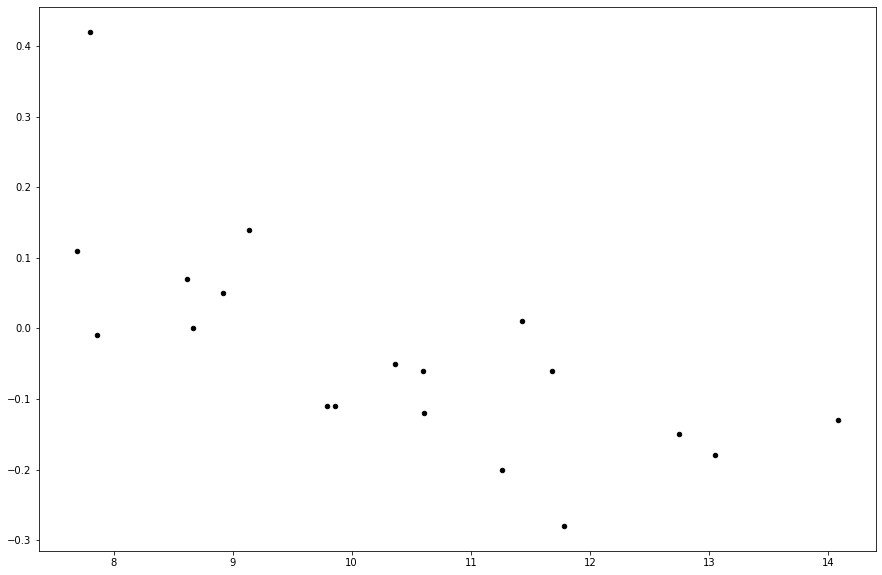

In [4]:
#First let's see what this data looks like
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')

# Cool! The data actually looks pretty linear so we can assume the function we are fitting *is* linear

In [5]:
# let's make a linear function the normal way
def linear(x, m, b):
    return m * x + b

raw:  -0.05818663749944188 0.5653511377902967
raw:  [ 0.00020654 -0.00213008] [-0.00213008  0.02264763]


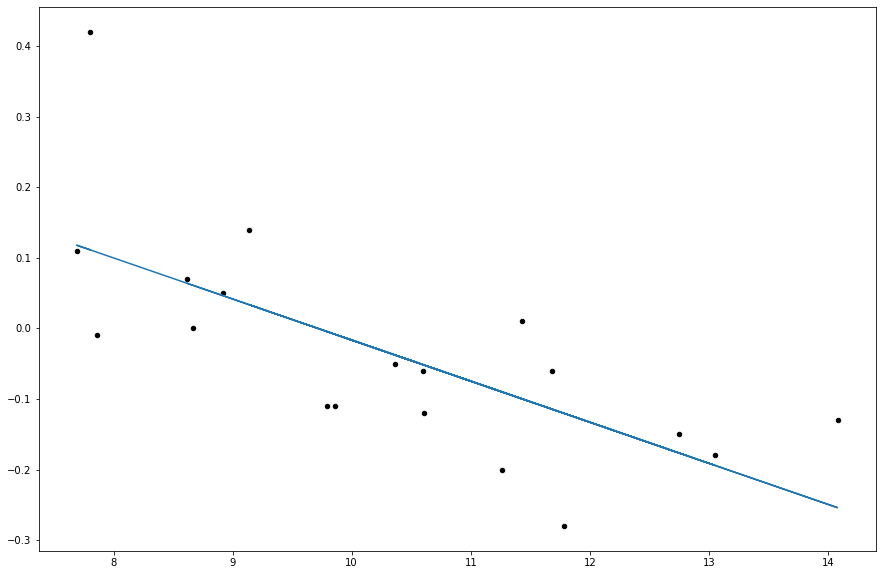

In [6]:
# let's do a linear fit to the data

popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)
print("raw: ", *pcov)


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))


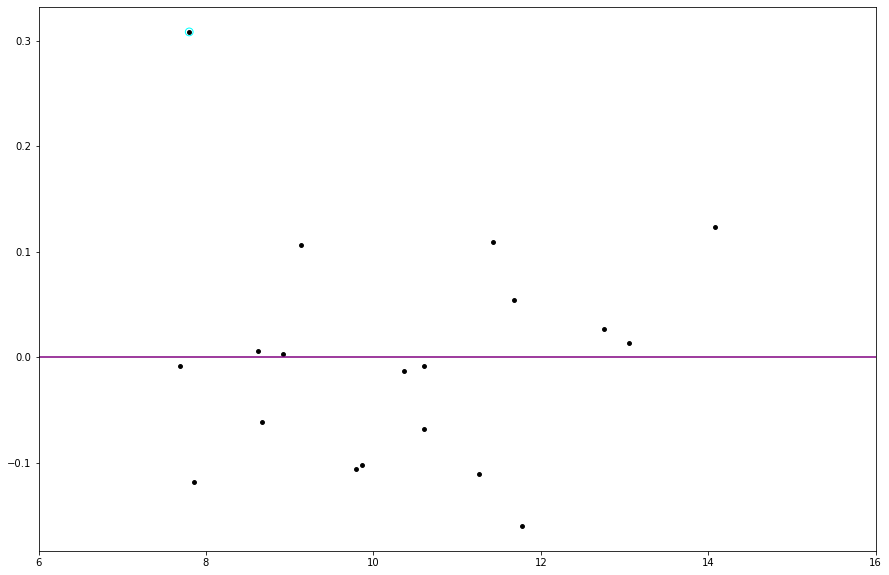

In [7]:
#Let's look into wich data are way off the fit.

residual = data['Y']-linear(data['X'],*popt) #how far real from our fit (how bad or good is our fit)
x = np.linspace(5,20,1000)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(6,16)

outlier = np.absolute(residual)>0.2
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')


raw:  -0.05818663749944188 0.5653511377902967
outliers accounted for:  -0.043381468377201124 0.3967292574963571


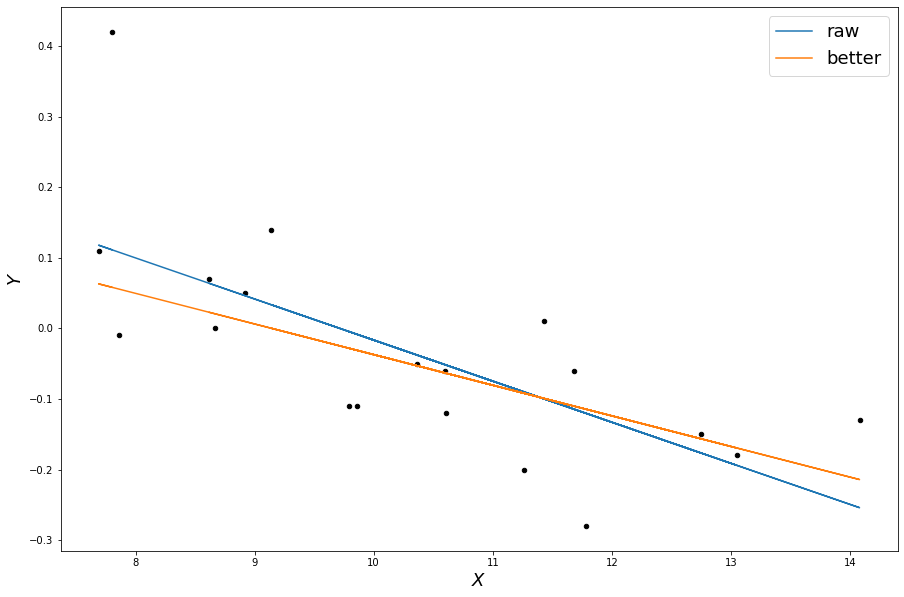

In [8]:
# our values for the raw data above:
# slope:    -0.058187
# intercept: 0.565351
popt, pcov = opt.curve_fit(linear, data['X'], data['Y']) #de-weight each data point, exclude what is far away
print("raw: ", *popt)

# we can use curve_fit to de-weight outliers automatically

# note, result is dependent on choice of loss function
# need to see method to trf in order to use least_squares instead of leastsq
popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Y'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
# cleaner error bars than last time, play around with the parameters
#ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
#            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

-0.038335615619586275 0.3463734445963487


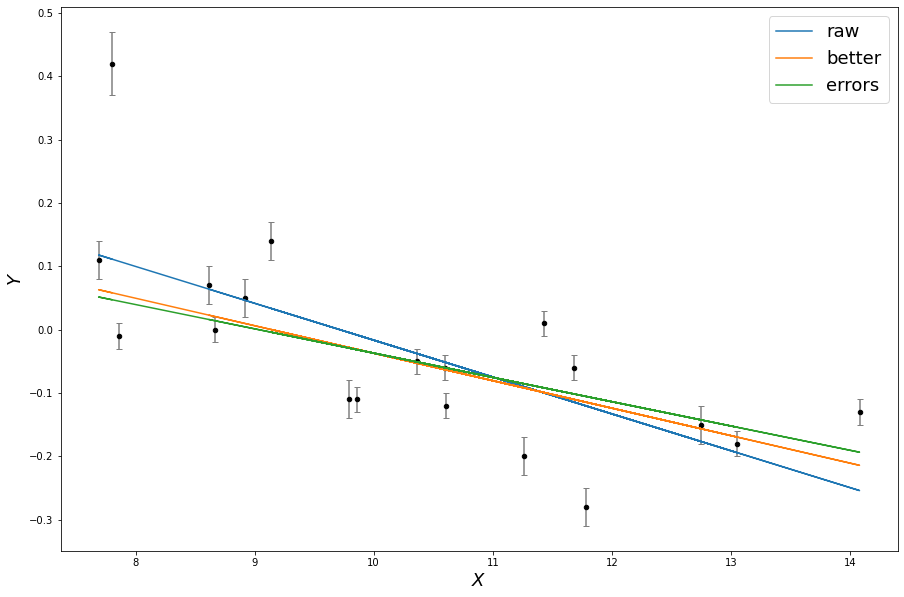

In [10]:
# lets account for the errors
# by pasing sigma, scipy knows to weight data according to their errors 
# naturally, sigma is expected to be the same size and correspond to y
# notice: this only accounts for y error
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: -0.0582, mean intercept: 0.5650


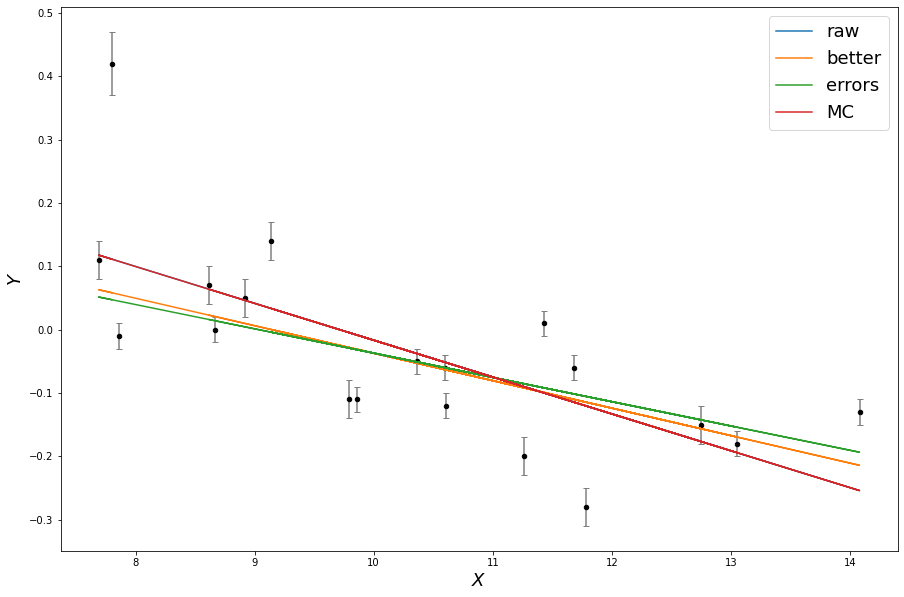

In [11]:
#if xalso have uncertanties, cannot use curve_fit
# Does this accurately explore the parameter space though?
# And what is the uncertainty on our data?
# What if we had x error bars?

# we'll explore a method utilizing the common "monte carlo" approach, take the randon number in error range
def mcFit(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500  #impacton the variations
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x  

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [12]:
# oh right, that outlier. let's mask outlier

mask = data['Y'] < 0.3

xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, ydat, ydat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")
# lets discuss monte carlo methods a little
for i in range(20):
    slope, intercept = mcFit(xdat, ydat, ydat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

# so what we see that our answer changes slightly, but its within the standard deviation
# of each set of measurements. So we can quote a reliable answer, with a reliable uncertainty

data size:  18
slope: -0.0432 $\pm$ 0.0032, mean intercept: 0.3920


slope: -0.0434 $\pm$ 0.0033, mean intercept: 0.3935
slope: -0.0436 $\pm$ 0.0032, mean intercept: 0.3948
slope: -0.0435 $\pm$ 0.0033, mean intercept: 0.3952
slope: -0.0435 $\pm$ 0.0032, mean intercept: 0.3949
slope: -0.0435 $\pm$ 0.0034, mean intercept: 0.3946
slope: -0.0437 $\pm$ 0.0032, mean intercept: 0.3969
slope: -0.0434 $\pm$ 0.0033, mean intercept: 0.3940
slope: -0.0436 $\pm$ 0.0033, mean intercept: 0.3963
slope: -0.0436 $\pm$ 0.0032, mean intercept: 0.3961
slope: -0.0433 $\pm$ 0.0033, mean intercept: 0.3928
slope: -0.0435 $\pm$ 0.0033, mean intercept: 0.3945
slope: -0.0432 $\pm$ 0.0033, mean intercept: 0.3914
slope: -0.0435 $\pm$ 0.0035, mean intercept: 0.3949
slope: -0.0434 $\pm$ 0.0035, mean intercept: 0.3930
slope: -0.0436 $\pm$ 0.0034, mean intercept: 0.3965
slope: -0.0437 $\pm$ 0.0034, mean intercept: 0.3974
slope: -0.0437 $\pm$ 0.0033, mean intercept: 0.3966
slope: -0.0434 $\pm$ 0.0033, mean intercept: 0.

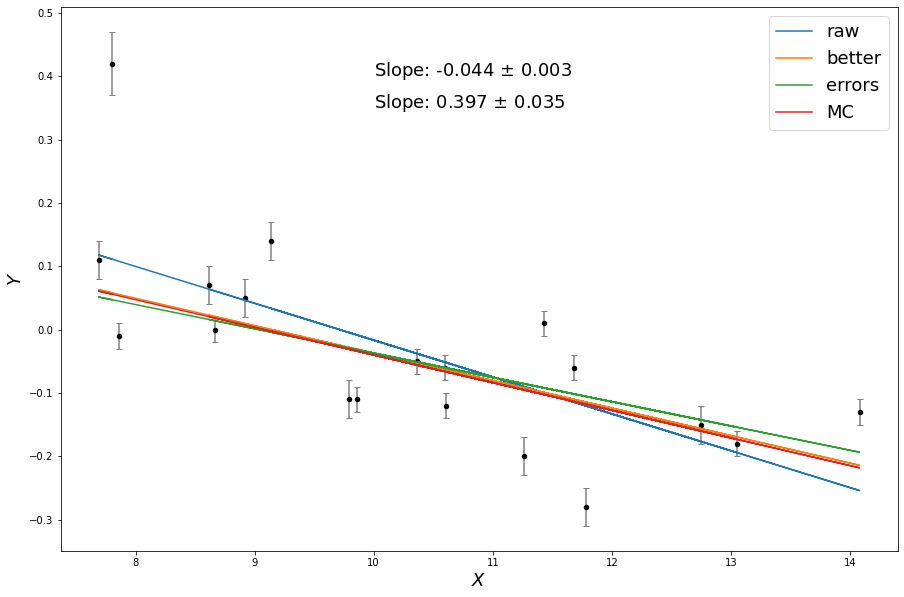

In [13]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slope, intercept = mcFit(xdat, ydat, ydat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

0.39632556548387265


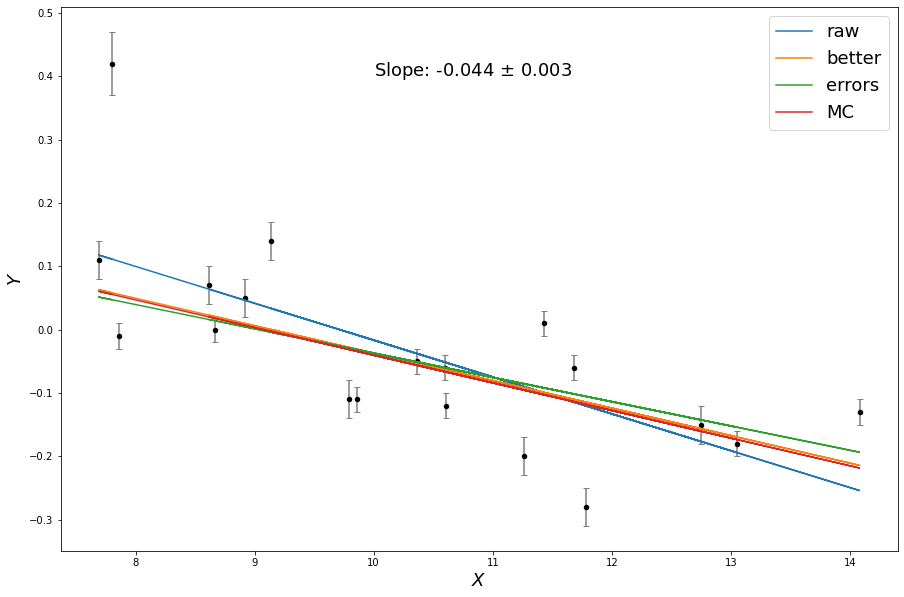

In [14]:
# here's an example of the use of lampda functions: simplifying or modifying another function
params, other = opt.curve_fit(lambda x, b: linear(x, np.mean(slope), b), xdat, ydat)

fixed_int = params[0]

print(fixed_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), fixed_int), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
# ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [ ]:
# exercise: we can't know the x data perfectly
# suppose the data have uniform x errors of 0.5 
# use the MC technique to estimate the slope *AND* the uncertainty taking into account these errors

# repeat this exercise, but supposing the errors INCREASE as we move away from X = 8 (as they do)
# to be precise: suppose X_ERR = |x - 8| /10, e.g. it increases by .1 per unit 
# plot both slopes. how does the fit change?

mean slope: -0.0546, mean intercept: 0.5289


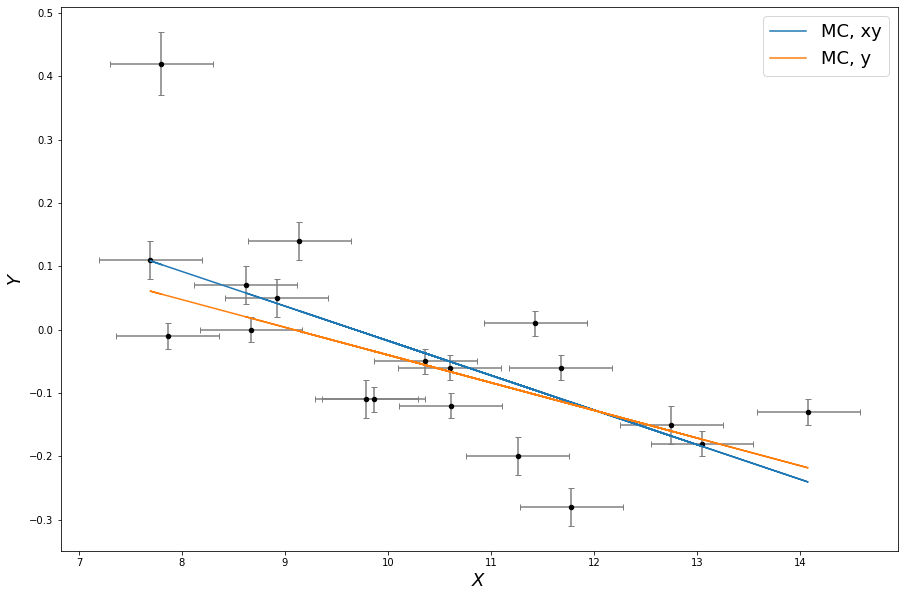

In [16]:
def mcFit(x, x_err, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500  #impacton the variations
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))   
        weightsy = np.random.randn(len(y)) 

        y_adj = y + y_err*weightsx
        x_adj = x + 0.5*weightsy

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope1, intercept1 = mcFit(data ['X'], data ['X']*0 + 0.5, data['Y'], data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope1), np.mean(intercept1)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'],xerr = data ['X']*0 + 0.5, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
#ax.plot(data['X'], linear(data['X'], *popt), label='raw')
#ax.plot(data['X'], linear(data['X'], *popt_err), label='slope')
ax.plot(data['X'], linear(data['X'], np.mean(slope1), np.mean(intercept1)), label='MC, xy')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC, y')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: -0.0571, mean intercept: 0.5534


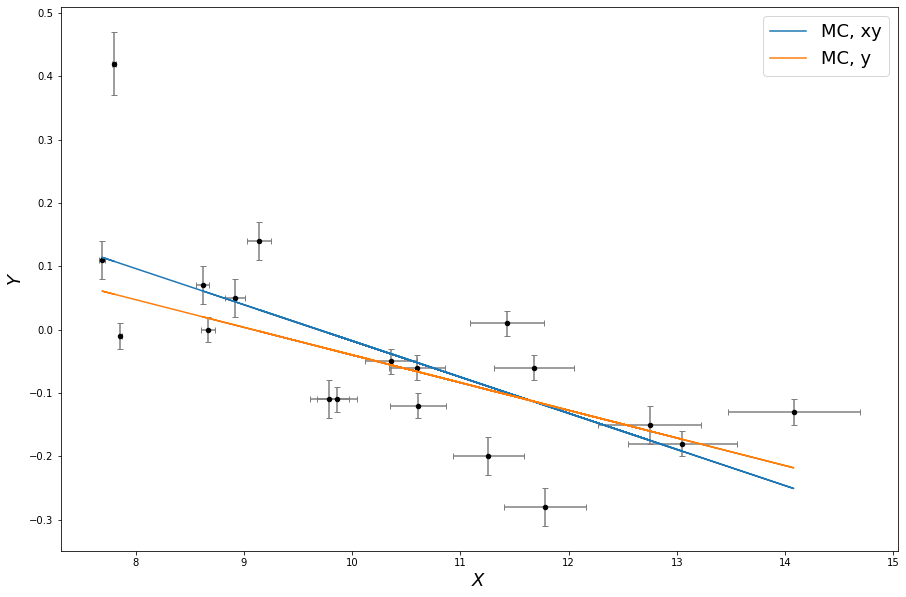

In [17]:
def mcFit(x, x_err, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500  #impacton the variations
    for i in range(iters):
        # remember random normal distribution (Gaussian)   
        weightsy = np.random.randn(len(y)) 
        weightsx = np.random.randn(len(y)) 

        y_adj = y + y_err*weightsy
        x_adj = x + (abs(x-8)/10)*weightsx

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope2, intercept2 = mcFit(data ['X'], abs(data ['X']-8)/10, data['Y'], data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope2), np.mean(intercept2)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], xerr = abs(data ['X']-8)/10, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
#ax.plot(data['X'], linear(data['X'], *popt), label='raw')
#ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
#ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope2), np.mean(intercept2)), label='MC, xy')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC, y')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

raw:  0.006717675713445995 -0.0687541345289338
raw:  [ 2.7536905e-05 -2.8399245e-04] [-0.00028399  0.00301949]


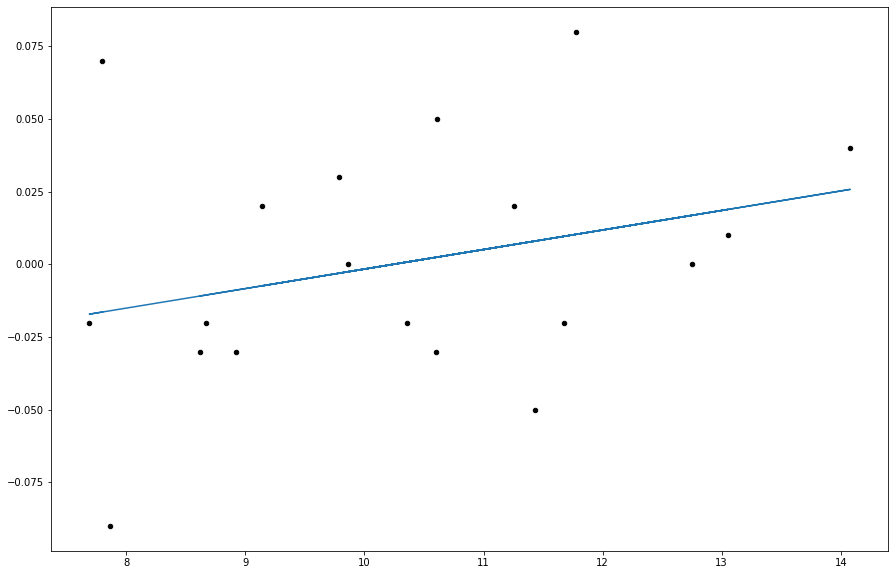

In [18]:
# Repeat the above anaysis for X vs. Z data, including uncertainties!! outliers???
def linear(x, a, c):
    return a * x + c

popt, pcov = opt.curve_fit(linear, data['X'], data['Z'])
print("raw: ", *popt)
print("raw: ", *pcov)


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Z'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))


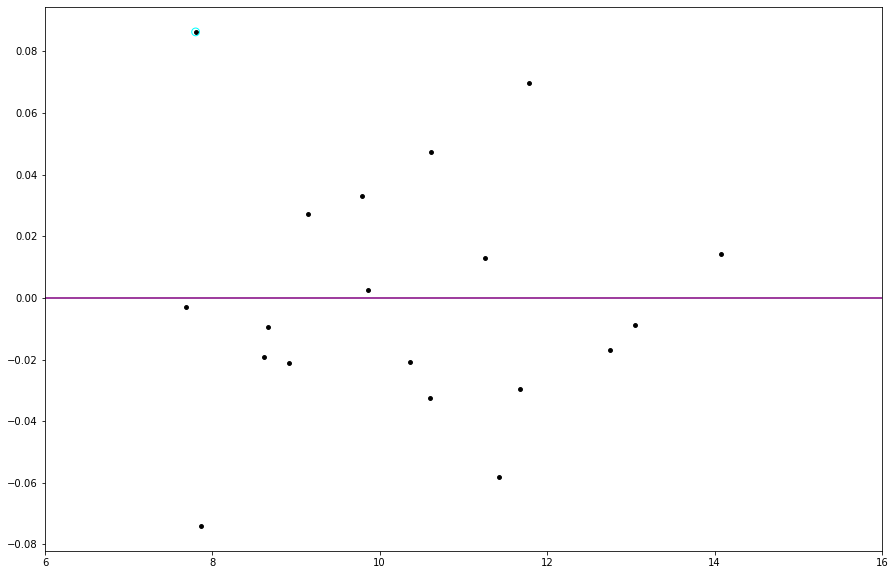

In [19]:
#Let's look into wich data are way off the fit.

residual = data['Z']-linear(data['X'],*popt) #how far real from our fit (how bad or good is our fit)
x = np.linspace(5,20,1000)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(6,16)

outlier = np.absolute(residual)>0.08
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')

raw:  0.006717675713445995 -0.0687541345289338
outliers accounted for:  0.00676670793429382 -0.06938331418907683


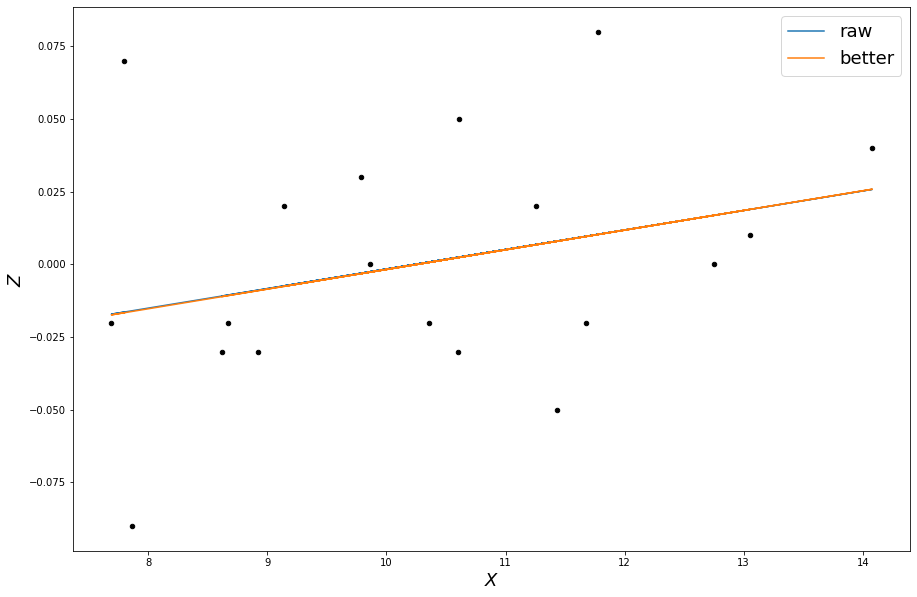

In [20]:
popt, pcov = opt.curve_fit(linear, data['X'], data['Z']) #de-weight each data point, exclude what is far away
print("raw: ", *popt)

# we can use curve_fit to de-weight outliers automatically

# note, result is dependent on choice of loss function
# need to see method to trf in order to use least_squares instead of leastsq
popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Z'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Z'],s=20,c='black',zorder=2)

# along with our fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

There are no outliers making a huge contribution to a fitting line

0.005358711605572734 -0.058178020691403


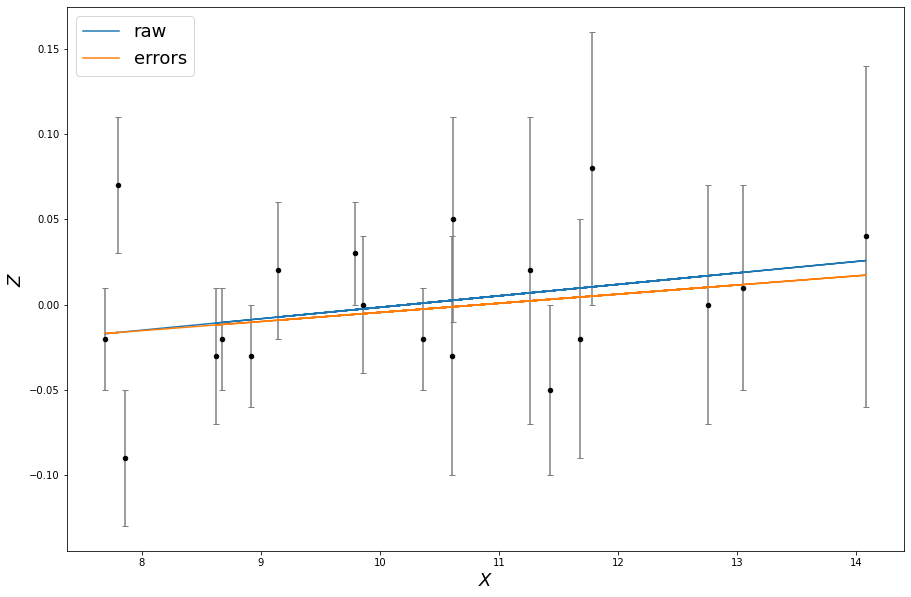

In [21]:
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Z'], sigma=data['Z_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
#ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: 0.0069, mean intercept: -0.0706


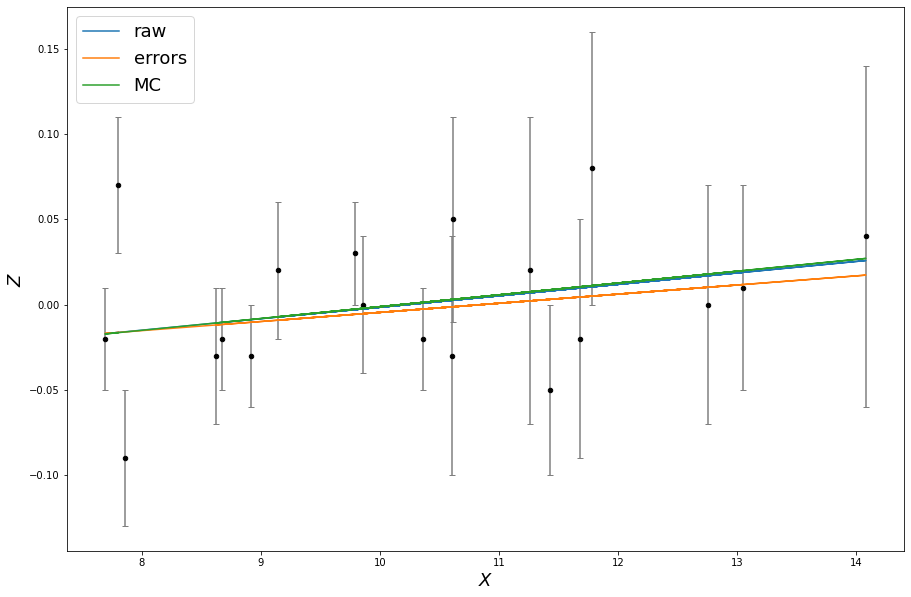

In [22]:
def mcFit(x, z, z_err):
    slopes = list()
    z_ints = list()
    iters = 500  #impacton the variations
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(z))

        z_adj = z + z_err*weights
        x_adj = x

        params, other = opt.curve_fit(linear, x_adj, z_adj)
        slopes.append(params[0])
        z_ints.append(params[1])
    
    return slopes, z_ints

slope, intercept = mcFit(data['X'], data['Z'], data['Z_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
#ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [23]:
# oh right, that outlier. let's mask outlier

mask = data['Z'] < 0.8

xdat = data['X'][mask]
zdat = data['Z'][mask]
zdat_err = data['Z_ERR'][mask]

print("data size: ", len(xdat))

slopez, interceptz = mcFit(xdat, zdat, zdat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")
# lets discuss monte carlo methods a little
for i in range(20):
    slope, intercept = mcFit(xdat, zdat, zdat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

# so what we see that our answer changes slightly, but its within the standard deviation
# of each set of measurements. So we can quote a reliable answer, with a reliable uncertainty

data size:  19
slope: +0.0069 $\pm$ 0.0079, mean intercept: -0.0706


slope: +0.0068 $\pm$ 0.0090, mean intercept: -0.0701
slope: +0.0067 $\pm$ 0.0087, mean intercept: -0.0694
slope: +0.0066 $\pm$ 0.0082, mean intercept: -0.0678
slope: +0.0066 $\pm$ 0.0083, mean intercept: -0.0683
slope: +0.0067 $\pm$ 0.0086, mean intercept: -0.0681
slope: +0.0052 $\pm$ 0.0084, mean intercept: -0.0543
slope: +0.0070 $\pm$ 0.0086, mean intercept: -0.0711
slope: +0.0072 $\pm$ 0.0084, mean intercept: -0.0737
slope: +0.0065 $\pm$ 0.0079, mean intercept: -0.0661
slope: +0.0062 $\pm$ 0.0085, mean intercept: -0.0638
slope: +0.0065 $\pm$ 0.0083, mean intercept: -0.0659
slope: +0.0076 $\pm$ 0.0078, mean intercept: -0.0761
slope: +0.0062 $\pm$ 0.0087, mean intercept: -0.0639
slope: +0.0068 $\pm$ 0.0084, mean intercept: -0.0693
slope: +0.0061 $\pm$ 0.0082, mean intercept: -0.0632
slope: +0.0065 $\pm$ 0.0081, mean intercept: -0.0669
slope: +0.0071 $\pm$ 0.0083, mean intercept: -0.0720
slope: +0.0073 $\pm$ 0.0079, 

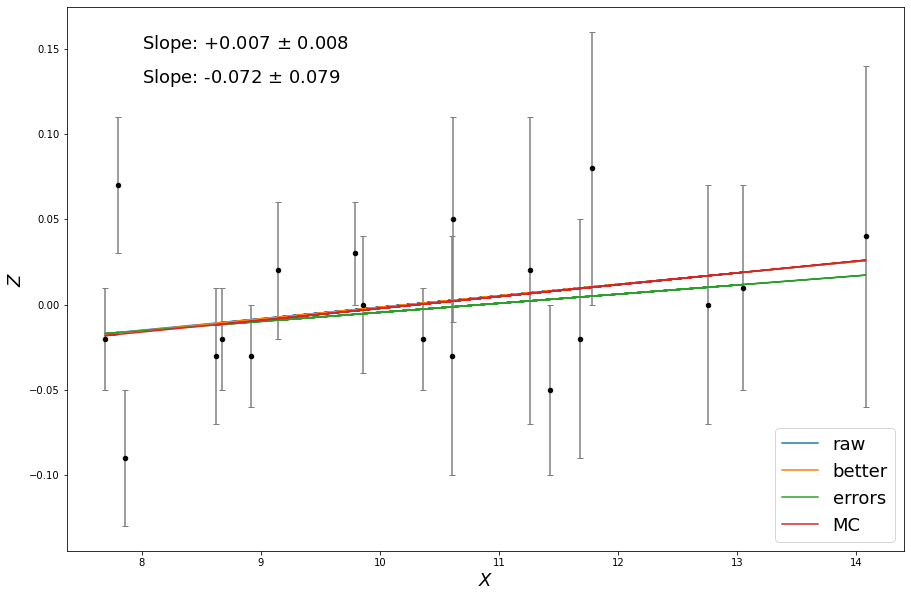

In [24]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'], yerr =data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slopez, interceptz = mcFit(xdat, zdat, zdat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slopez), np.mean(interceptz)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

ax.text(8, 0.15, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slopez), np.std(slopez)), fontsize=18)
ax.text(8, 0.13, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(interceptz), np.std(interceptz)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: 0.0063, mean intercept: -0.0645


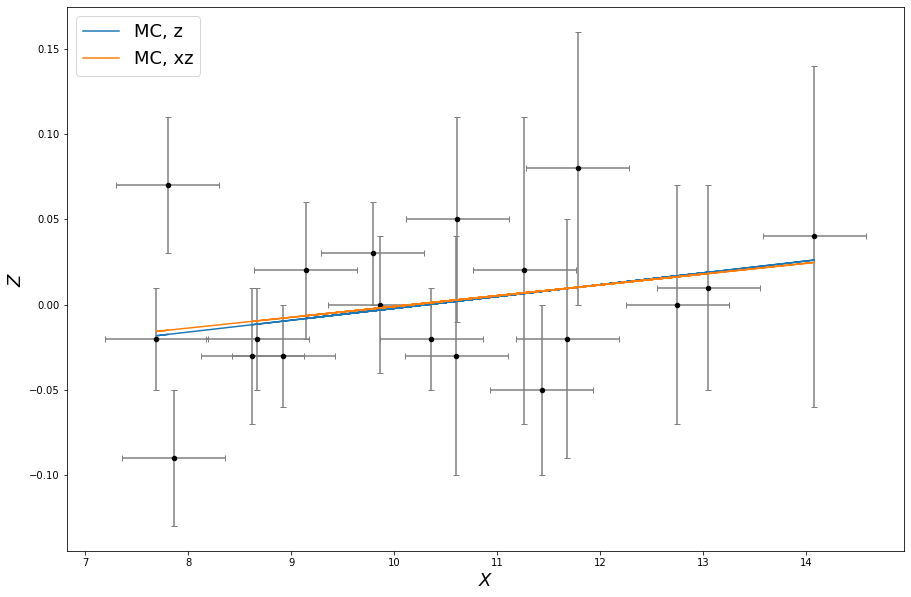

In [25]:
def mcFit(x, x_err, z, z_err):
    slopes = list()
    z_ints = list()
    iters = 500  #impacton the variations
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(z))   
        weightsz = np.random.randn(len(z)) 

        z_adj = z + z_err*weightsx
        x_adj = x + 0.5*weightsz

        params, other = opt.curve_fit(linear, x_adj, z_adj)
        slopes.append(params[0])
        z_ints.append(params[1])
    
    return slopes, z_ints

slopez1, interceptz1 = mcFit(data ['X'], data ['X']*0 + 0.5, data['Z'], data['Z_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slopez1), np.mean(interceptz1)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'],yerr=data['Z_ERR'],xerr = data ['X']*0 + 0.5, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
#ax.plot(data['X'], linear(data['X'], *popt), label='raw')
#ax.plot(data['X'], linear(data['X'], *popt_err), label='slope')
ax.plot(data['X'], linear(data['X'], np.mean(slopez), np.mean(interceptz)), label='MC, z')
ax.plot(data['X'], linear(data['X'], np.mean(slopez1), np.mean(interceptz1)), label='MC, xz')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: 0.0064, mean intercept: -0.0649


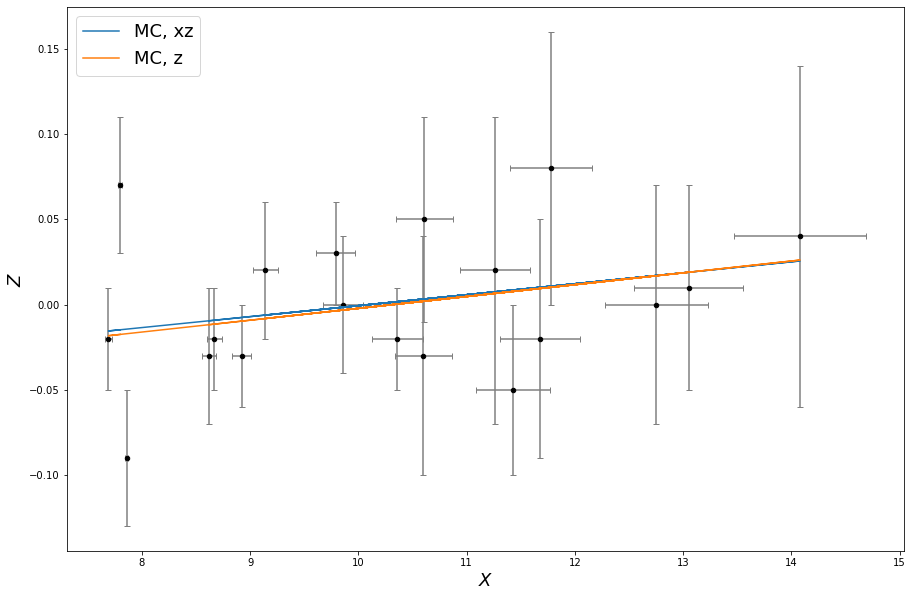

In [26]:
def mcFit(x, x_err, z, z_err):
    slopes = list()
    z_ints = list()
    iters = 500  #impacton the variations
    for i in range(iters):
        # remember random normal distribution (Gaussian)   
        weightsz = np.random.randn(len(z)) 
        weightsx = np.random.randn(len(z)) 

        z_adj = z + z_err*weightsz
        x_adj = x + (abs(x-8)/10)*weightsx

        params, other = opt.curve_fit(linear, x_adj, z_adj)
        slopes.append(params[0])
        z_ints.append(params[1])
    
    return slopes, z_ints

slopez2, interceptz2 = mcFit(data ['X'], abs(data ['X']-8)/10, data['Z'], data['Z_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slopez2), np.mean(interceptz2)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'],yerr=data['Z_ERR'], xerr = abs(data ['X']-8)/10, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], np.mean(slopez2), np.mean(interceptz2)), label='MC, xz')
ax.plot(data['X'], linear(data['X'], np.mean(slopez), np.mean(interceptz)), label='MC, z')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()